In [36]:
import tensorflow as tf
import sys, imageio, os
sys.path.append("/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project")
from models.model import *
from models.data_prepare import *
import keras

In [18]:
X, y = data("vary_width")
# bin2 so the pixel shrink, need to time 2 to correct it.
y = y*2

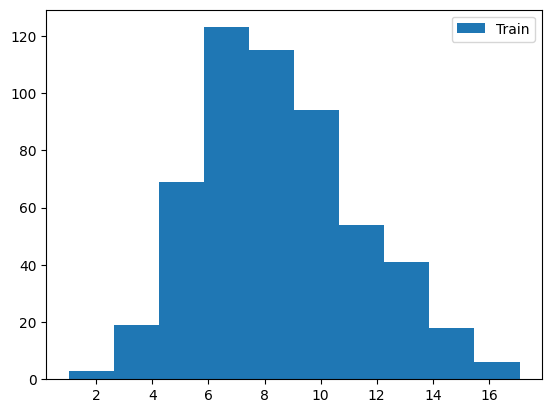

In [3]:
import matplotlib.pyplot as plt
plt.hist(y,label="Train")
plt.legend()
plt.show()

In [19]:
X_train,y_train = data("varying_lum_and_focus_train")
X_test,y_test = data("varying_lum_and_focus_test")

In [20]:
X_combine = np.concatenate([X_train,X_test,X], axis=0)
y_combine = np.concatenate([y_train,y_test,y], axis=0)

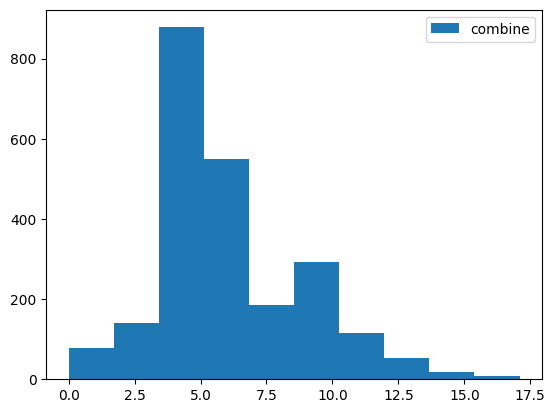

In [6]:
plt.hist(y_combine,label="combine")
plt.legend()
plt.show()

In [21]:
# Make sure the train, validation, test set is 60,20,20.
X_train, X_test, y_train, y_test = train_test_split(X_combine, y_combine, test_size=0.2, random_state=42,shuffle=True)
X_train, X_val, y_train , y_val   = train_test_split(X_train, y_train, test_size=0.25  , random_state=42,shuffle=True)

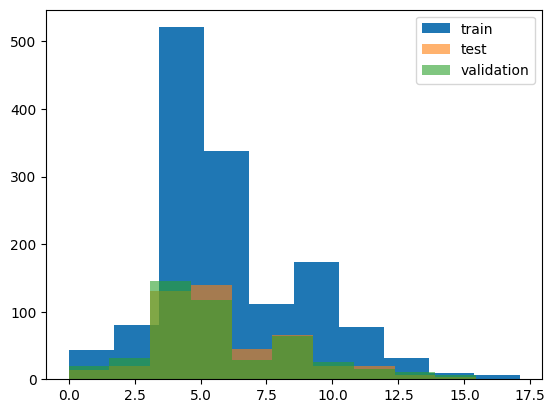

In [8]:
plt.hist(y_train,label="train")
plt.hist(y_test,label="test",alpha=0.6)
plt.hist(y_val,label="validation",alpha=0.6)
plt.legend()
plt.show()

In [9]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape, X_val.shape,y_val.shape

((1391, 120), (1391, 1), (464, 120), (464, 1), (464, 120), (464, 1))

In [10]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        # "no longer improving" being defined as "no better than 1e-3 less"
        # "no longer improving" being further defined as "for at least 3 epochs"
        monitor="val_mean_absolute_error",
        min_delta=1e-3,
        patience=3,
        verbose=1),]

In [11]:
def build_model(hp):
    # input_size = hp.Fixed("input", 120)
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(120, 1)))
    model.add(keras.layers.Rescaling(1 / 127.5, offset=-1))
    for i in range(hp.Int("num_conv_layers", 1, 4, default=2)):
        model.add(keras.layers.Conv1D(
            filters=hp.Int(f"filters_{i + 1}", min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[10,11,12,13,14,15,16, 17,18,19,20]),
            activation="relu",
            name=f"conv_{i + 1}",
            kernel_regularizer=keras.regularizers.L1(
                hp.Float("kernel_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            activity_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            bias_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log"))))
    hp_pooling = hp.Choice(f'pooling_{i}', values=["MP", "AP", "No pool"])
    hp_padding = hp.Choice('padding_' + str(i), values=['valid', 'same'])
    if hp_pooling == "MP":
        model.add(keras.layers.MaxPooling1D(hp.Int(f"MP", min_value=1, max_value=4, step=1),padding = hp_padding))
    if hp_pooling == "AP":
        model.add(keras.layers.AveragePooling1D(hp.Int(f"AP", min_value=1, max_value=4, step=1),padding = hp_padding))
    if hp.Boolean("batch_normalization", default=False):
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Flatten())
    for j in range(hp.Int("num_dense_layers", 1, 4, default=2)):
        model.add(keras.layers.Dense(
            units=hp.Int("dense_size", min_value=8, max_value=256, step=32), activation="relu",
            name=f"dense_{j + 1}",
            kernel_regularizer=keras.regularizers.L1(
                hp.Float("kernel_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            activity_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log")),
            bias_regularizer=keras.regularizers.L1(
                hp.Float("activity_regulizer", min_value=1e-5, max_value=1e-1, sampling="log"))))
        model.add(keras.layers.Dropout(hp.Float(f"dropout_{j + 1}", 0, 0.5, step=0.1, default=0.2)))
    model.add(keras.layers.Dense(units=1, activation=None, name="output"))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Float("learning_rate", min_value=1e-5, max_value=1e-1, sampling="log", default=1e-3)),
        loss="mean_squared_error",
        metrics="mean_absolute_error")
    return model

In [ ]:
tuner_BO = tuning_model(build_model, callbacks, 
                        X_train, y_train, X_val, y_val,
                        model_type="BO", 
                        project="/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/models/CNN_combine_BO_without_crop")
best_model, best_model_hp, history = hp_model_output_information(tuner_BO,X_train, y_train, X_test, y_test)
best_model.save("/home/ipausers/lin/Desktop/Kai/Graduation-Project/models/BO_without_crop_best_model")

Trial 98 Complete [00h 00m 32s]
val_mean_absolute_error: 0.892357587814331

Best val_mean_absolute_error So Far: 0.8039678335189819
Total elapsed time: 05h 01m 48s


In [ ]:
tuner_HB = tuning_model(build_model, callbacks, 
                        X_train, y_train, X_val, y_val,
                        model_type="HB", 
                        project="/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/models/CNN_combine_HB_without_crop")
best_model, best_model_hp, history = hp_model_output_information(tuner_HB,X_train, y_train, X_test, y_test)
best_model.save("/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/models/bin2_HB_without_crop_best_model_val_version")

In [82]:
def get_model(name):
    model_save = "/home/ipausers/lin/Desktop/Graduation/Kai/Graduation-Project/models/"
    return os.path.join(model_save,name)
BO_without = keras.models.load_model(get_model("bin2_BO_without_crop_best_model_val_version"))
BO_100 = keras.models.load_model(get_model("bin2_BO_crop_100_best_model_val_version"))
BO_80 = keras.models.load_model(get_model("bin2_BO_crop_80_best_model_val_version"))
HB_without = keras.models.load_model(get_model("bin2_HB_without_crop_best_model_val_version"))
HB_100 = keras.models.load_model(get_model("bin2_HB_crop_100_best_model_val_version"))
HB_80 = keras.models.load_model(get_model("bin2_HB_crop_80_best_model_val_version"))
felix = keras.models.load_model("/home/ipausers/lin/Desktop/Graduation/AMFtrack/amftrack/ml/models/default_model")
HB_model = [HB_without,HB_100,HB_80]
BO_model = [BO_without,BO_100,BO_80]
HB_label = ["HB_without","HB_100","HB_80"]
BO_label = ["BO_without","BO_100","BO_80"]
data_preparation_value=[120,100,80]

In [84]:
HB_accuracy = []
for i in range(len(HB_model)):
    HB_accuracy.append([])
BO_accuracy = []
for i in range(len(BO_model)):
    BO_accuracy.append([])
felix_accuracy=[]

def data_preparation(X_test,size=OUTPUTSIZE):
    data_preprocessing = keras.Sequential([
        tf.keras.Input(shape=(IMAGESIZE, 1)),
        center_crop_layer(IMAGESIZE, size)])
    return data_preprocessing(X_test)

from sklearn.utils import resample
import matplotlib.pyplot as plt
n_iterations = 1000
for _ in range(n_iterations):
    X_bs, y_bs = resample(X_test, y_test, replace=True,n_samples=50)
    i = 0
    loss, acc = HB_model[i].evaluate(X_bs,y_bs,verbose=1)
    HB_accuracy[i].append(acc)
    loss, acc = BO_model[i].evaluate(X_bs,y_bs,verbose=1)
    BO_accuracy[i].append(acc)
    for i in range(1,3):
        loss, acc = BO_model[i].evaluate(data_preparation(X_bs,size = data_preparation_value[i]),y_bs,verbose=1)
        BO_accuracy[i].append(acc)
        loss, acc = HB_model[i].evaluate(data_preparation(X_bs,size = data_preparation_value[i]),y_bs,verbose=1)
        HB_accuracy[i].append(acc)
    loss, acc = felix.evaluate(data_preparation(X_bs,100),y_bs,verbose=1)
    felix_accuracy.append(acc)

2/2 [==============================] - 0s 2ms/step - loss: 6.6958 - mean_absolute_error: 1.4121


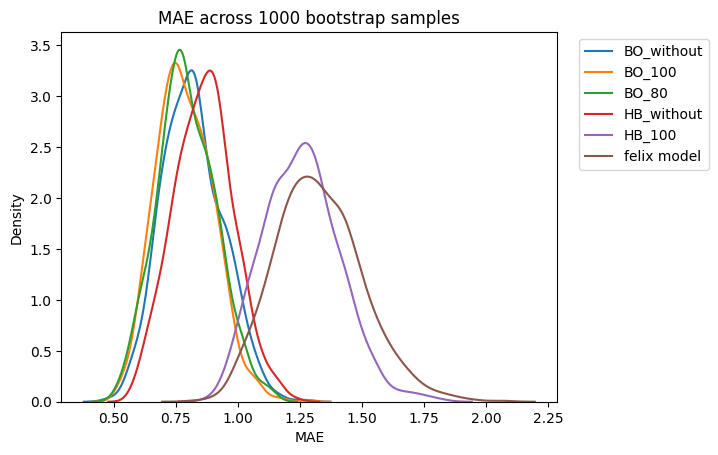

In [103]:
import seaborn as sns
# Check MAE
# plot distribution of accuracy
for i in range(len(BO_accuracy)):
    sns.kdeplot(BO_accuracy[i],label=BO_label[i])
for i in range(len(HB_accuracy)):
    sns.kdeplot(HB_accuracy[i],label=HB_label[i])
i=0
sns.kdeplot(HB_accuracy[i],label=HB_label[i])
i=1
sns.kdeplot(HB_accuracy[i],label=HB_label[i])
sns.kdeplot(felix_accuracy,label="felix model")
# plt.xlim(0,5)
plt.legend(bbox_to_anchor=(1.03, 1),loc='upper left')
plt.title("MAE across 1000 bootstrap samples")
plt.xlabel("MAE")
plt.savefig("plot_data/BootstrapingModel_ME.png",bbox_inches="tight")

In [86]:
HB_accuracy_RE = []
for i in range(len(HB_model)):
    HB_accuracy_RE.append([])
BO_accuracy_RE = []
for i in range(len(BO_model)):
    BO_accuracy_RE.append([])
felix_accuracy_RE = []

In [87]:
for _ in range(n_iterations):
    X_bs, y_bs = resample(X_test, y_test, replace=True,n_samples=50)
    i = 0
    RE = np.mean(abs(HB_model[i].predict(X_bs)-y_bs)/y_bs)
    HB_accuracy_RE[i].append(RE)
    RE = np.mean(abs(BO_model[i].predict(X_bs)-y_bs)/y_bs)
    BO_accuracy_RE[i].append(RE)
    for i in range(1,3):
        RE = np.mean(abs(BO_model[i].predict(data_preparation(X_bs,data_preparation_value[i]))-y_bs)/y_bs)
        BO_accuracy_RE[i].append(RE)
        RE = np.mean(abs(HB_model[i].predict(data_preparation(X_bs,data_preparation_value[i]))-y_bs)/y_bs)
        HB_accuracy_RE[i].append(RE)
    RE = np.mean(abs(felix.predict(data_preparation(X_bs,100))-y_bs)/y_bs)
    felix_accuracy_RE.append(RE)

2/2 [==============================] - 0s 5ms/step


/tmp/ipykernel_2502808/2920510447.py:4: RuntimeWarning: divide by zero encountered in divide
  RE = np.mean(abs(HB_model[i].predict(X_bs)-y_bs)/y_bs)
/tmp/ipykernel_2502808/2920510447.py:6: RuntimeWarning: divide by zero encountered in divide
  RE = np.mean(abs(BO_model[i].predict(X_bs)-y_bs)/y_bs)


2/2 [==============================] - 0s 7ms/step


/tmp/ipykernel_2502808/2920510447.py:9: RuntimeWarning: divide by zero encountered in divide
  RE = np.mean(abs(BO_model[i].predict(data_preparation(X_bs,data_preparation_value[i]))-y_bs)/y_bs)


2/2 [==============================] - 0s 5ms/step


/tmp/ipykernel_2502808/2920510447.py:11: RuntimeWarning: divide by zero encountered in divide
  RE = np.mean(abs(HB_model[i].predict(data_preparation(X_bs,data_preparation_value[i]))-y_bs)/y_bs)


2/2 [==============================] - 0s 7ms/step


/tmp/ipykernel_2502808/2920510447.py:13: RuntimeWarning: divide by zero encountered in divide
  RE = np.mean(abs(felix.predict(data_preparation(X_bs,100))-y_bs)/y_bs)


2/2 [==============================] - 0s 5ms/step


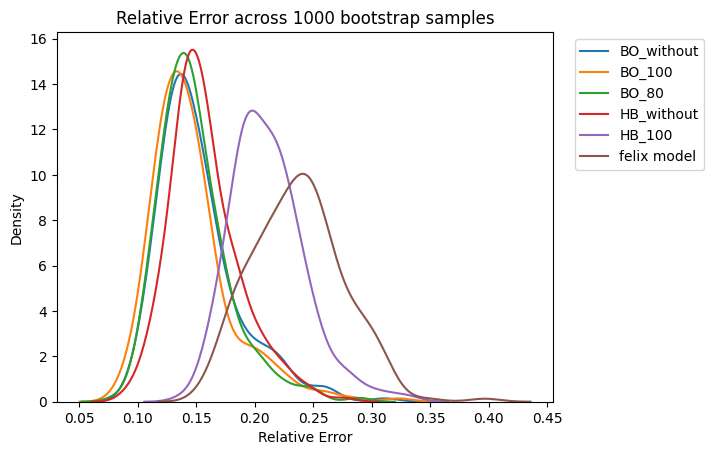

In [102]:
# Check RE
for i in range(len(BO_model)):
    sns.kdeplot(BO_accuracy_RE[i],label=BO_label[i])
# for i in range(len(HB_model)):
#     sns.kdeplot(HB_accuracy_RE[i],label=HB_label[i])
i=0
sns.kdeplot(HB_accuracy_RE[i],label=HB_label[i])
i=1
sns.kdeplot(HB_accuracy_RE[i],label=HB_label[i])
sns.kdeplot(felix_accuracy_RE,label="felix model")
plt.legend(bbox_to_anchor=(1.03, 1),loc='upper left')
plt.title("Relative Error across 1000 bootstrap samples")
plt.xlabel("Relative Error")
plt.savefig("plot_data/BootstrapingModel_RE.png",bbox_inches="tight")

15/15 [==============================] - 0s 25ms/step
coefficient of determination: 0.7993048315195788
15/15 [==============================] - 0s 8ms/step
coefficient of determination: 0.8089541821312937
15/15 [==============================] - 0s 15ms/step
coefficient of determination: 0.6221744408735514
15/15 [==============================] - 0s 23ms/step
coefficient of determination: 0.7572974241727858
15/15 [==============================] - 0s 18ms/step
coefficient of determination: 0.8275368738361386
15/15 [==============================] - 0s 8ms/step
coefficient of determination: 0.8225169098636128
15/15 [==============================] - 0s 2ms/step
coefficient of determination: 0.5344068709038264
15/15 [==============================] - 0s 2ms/step


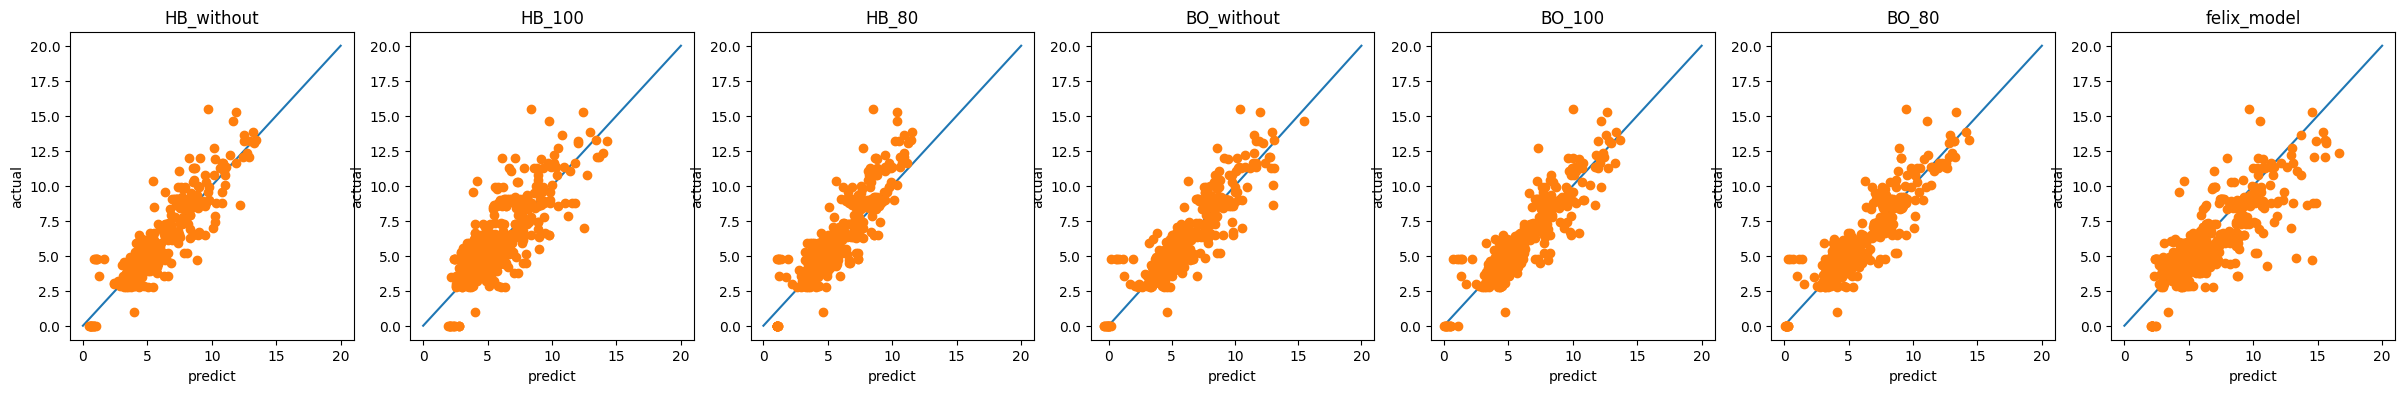

In [106]:
# Check combine
fig = plt.figure(figsize=(30, 4))
total_model = len(HB_model)+len(BO_model)+1
i=0
compare_different_model(HB_model[i], X_test, y_test, x_range=[0,20], set_title=HB_label[i], total=total_model, plot_number=i+1)
compare_different_model(BO_model[i], X_test, y_test, x_range=[0,20], set_title=BO_label[i], total=total_model, plot_number=len(HB_model)+1)
for i in range(1,len(HB_model)):
    compare_different_model(HB_model[i], data_preparation(X_test,data_preparation_value[i]), y_test, x_range=[0,20], set_title=HB_label[i], total=total_model, plot_number=i+1)
for j in range(1,len(BO_model)):
    compare_different_model(BO_model[j], data_preparation(X_test,data_preparation_value[j]), y_test, x_range=[0,20], set_title=BO_label[j], total=total_model, plot_number=len(HB_model)+j+1)
compare_different_model(felix, data_preparation(X_test,100), y_test, x_range=[0,20], set_title="felix_model", total=total_model, plot_number=total_model)
plt.savefig("plot_data/compare_model/20230112 HB vs BO.png")

In [90]:
# Check seperate
sfm1_X,sfm1_y = data("single_focus_-0.1_test")
sfp1_X,sfp1_y = data("single_focus_0.1_test")
sf_X, sf_y = data("single_focus_0.0_test")
slm1_X,slm1_y = data("single_lum_-100_focus_0_test")
slm2_X,slm2_y = data("single_lum_-200_focus_0_test")
slp1_X,slp1_y = data("single_lum_100_focus_0_test")
slp2_X,slp2_y = data("single_lum_200_focus_0_test")
new_X,new_y = data("vary_width")
new_y = new_y*2
# X_dataset_seperate_crop = [data_preparation(sfm1_X), data_preparation(sf_X)  , data_preparation(sfp1_X), 
#                       data_preparation(slm1_X), data_preparation(slm2_X),
#                       data_preparation(slp1_X), data_preparation(slp2_X),
#                       data_preparation(new_X)]
X_dataset_seperate = [sfm1_X, sf_X  , sfp1_X, 
                      slm1_X, slm2_X,
                      slp1_X, slp2_X,
                      new_X]
X_dataset_seperate_80 = []
X_dataset_seperate_100 = []
for i in range(len(X_dataset_seperate)):
    X_dataset_seperate_80.append(data_preparation(X_dataset_seperate[i],80))
    X_dataset_seperate_100.append(data_preparation(X_dataset_seperate[i],100))
X_dataset = [X_dataset_seperate,X_dataset_seperate_100,X_dataset_seperate_80]
y_dataset_seperate = [sfm1_y, sf_y, sfp1_y,
                      slm1_y, slm2_y,
                      slp1_y, slp2_y,
                      new_y]
label_dataset_seperate = ["single focus -0.1", "single focus",   "single focus 0.1",
                          "single lum -100"  , "single lum -200",
                          "single lum 100"   , "single lum 200",
                          "new dataset"]

17/17 [==============================] - 0s 13ms/step


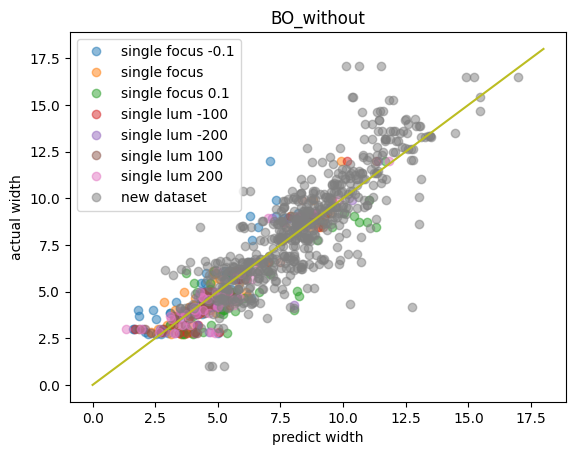

In [107]:
def plot_seperate(model_list,model_number, X_list, y_list,dataset_choose,dot,label_list,alpha=1):
    plt.plot(model_list[model_number].predict(X_list[dataset_choose]), y_list[dataset_choose],dot, label=label_list[dataset_choose],alpha=alpha)
    return plt
for i in range(len(label_dataset_seperate)):
    plot_seperate(BO_model,0,X_dataset[0],y_dataset_seperate,i,"o",label_dataset_seperate,alpha = 0.5)
plt.plot([0,18],[0,18])
plt.xlabel("predict width")
plt.ylabel("actual width")
plt.legend()
plt.title(BO_label[0])
plt.savefig("plot_data/compare_model/BO_without.png")

17/17 [==============================] - 0s 20ms/step


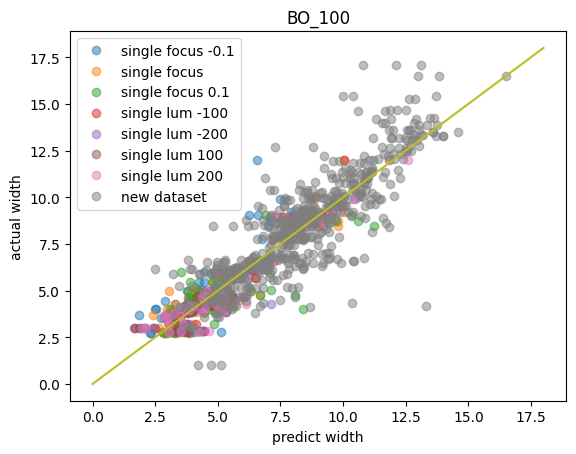

In [108]:
for i in range(len(label_dataset_seperate)):
    plot_seperate(BO_model,1,X_dataset[1],y_dataset_seperate,i,"o",label_dataset_seperate,alpha = 0.5)
plt.plot([0,18],[0,18])
plt.xlabel("predict width")
plt.ylabel("actual width")
plt.legend()
plt.title(BO_label[1])
plt.savefig("plot_data/compare_model/BO_100.png")

17/17 [==============================] - 0s 7ms/step


Text(0.5, 1.0, 'BO_80')

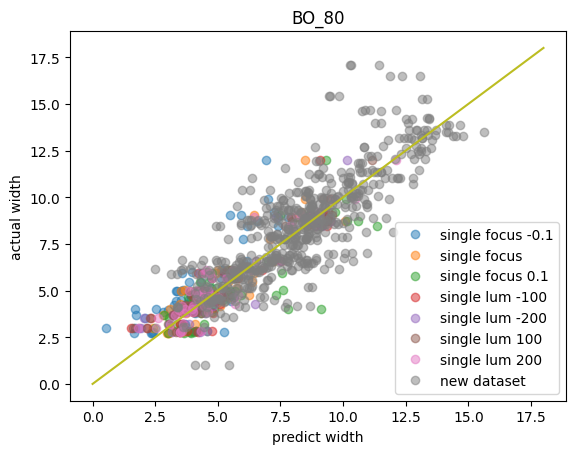

In [93]:
for i in range(len(label_dataset_seperate)):
    plot_seperate(BO_model,2,X_dataset[2],y_dataset_seperate,i,"o",label_dataset_seperate,alpha = 0.5)
plt.plot([0,18],[0,18])
plt.xlabel("predict width")
plt.ylabel("actual width")
plt.legend()
plt.title(BO_label[2])

In [ ]:
# Visualize-Architecture
# https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network